# Task 3 - Modeling

Task 3 of Cognizant Artificial Intelligence virtual experience at The Forage. Modeling data of sales, storage temperature, stock level to predict number of product stock in the storage. Provide feature importance also. I'm going to try to use random forest for this task.

Nugroho Budianggoro, 23-04-2023

In [65]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
from google.colab import drive
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import os
import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler


In [68]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the raw data.

In [69]:
path = "/content/drive/MyDrive/Virtual Experience/"

df_sales = pd.read_csv(f"{path}sales.csv")
df_sales.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
df_sales.head(2)

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:51:38,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet
1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:33:59,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet


In [70]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7829 entries, 0 to 7828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  7829 non-null   object 
 1   timestamp       7829 non-null   object 
 2   product_id      7829 non-null   object 
 3   category        7829 non-null   object 
 4   customer_type   7829 non-null   object 
 5   unit_price      7829 non-null   float64
 6   quantity        7829 non-null   int64  
 7   total           7829 non-null   float64
 8   payment_type    7829 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 550.6+ KB


In [71]:
df_stock = pd.read_csv(f"{path}sensor_stock_levels.csv")
df_stock.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
df_stock.head(2)

,id,timestamp,product_id,estimated_stock_pct
0,4220e505-c247-478d-9831-6b9f87a4488a,2022-03-07 12:13:02,f658605e-75f3-4fed-a655-c0903f344427,0.75
1,f2612b26-fc82-49ea-8940-0751fdd4d9ef,2022-03-07 16:39:46,de06083a-f5c0-451d-b2f4-9ab88b52609d,0.48


In [72]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  object 
 1   timestamp            15000 non-null  object 
 2   product_id           15000 non-null  object 
 3   estimated_stock_pct  15000 non-null  float64
dtypes: float64(1), object(3)
memory usage: 468.9+ KB


In [73]:
df_tempr = pd.read_csv(f"{path}sensor_storage_temperature.csv")
df_tempr.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
df_tempr.head(2)

,id,timestamp,temperature
0,d1ca1ef8-0eac-42fc-af80-97106efc7b13,2022-03-07 15:55:20,2.96
1,4b8a66c4-0f3a-4f16-826f-8cf9397e9d18,2022-03-01 09:18:22,1.88


In [74]:
df_tempr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23890 entries, 0 to 23889
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           23890 non-null  object 
 1   timestamp    23890 non-null  object 
 2   temperature  23890 non-null  float64
dtypes: float64(1), object(2)
memory usage: 560.0+ KB


All the timestamp columns need data type converting. Later.

Copy the raw data just in case.

In [75]:
df_sales_copy = df_sales.copy()
df_tempr_copy = df_tempr.copy()
df_stock_copy = df_stock.copy()

Create function to convert raw date time data to date time hourly data.

In [76]:
def get_hourly_data(df):
  # df = data.copy()
  df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
  ts = df['timestamp'].tolist()
  ts = [i.strftime('%Y-%m-%d %H:00:00') for i in ts]
  ts = [datetime.strptime(i, '%Y-%m-%d %H:00:00') for i in ts]
  df['timestamp'] = ts
  return df

Convert date time data to hourly date time data in all data frames.

In [77]:
dfs = [df_sales, df_stock, df_tempr]

for df_i in dfs:
  df_i = get_hourly_data(df_i)

Process the sales data.

In [78]:
df_sales.head()

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:00:00,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet
1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:00:00,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet
2,ae133534-6f61-4cd6-b6b8-d1c1d8d90aea,2022-03-04 17:00:00,7c55cbd4-f306-4c04-a030-628cbe7867c1,fruit,premium,0.19,2,0.38,e-wallet
3,157cebd9-aaf0-475d-8a11-7c8e0f5b76e4,2022-03-02 17:00:00,80da8348-1707-403f-8be7-9e6deeccc883,fruit,gold,0.19,4,0.76,e-wallet
4,a81a6cd3-5e0c-44a2-826c-aea43e46c514,2022-03-05 14:00:00,7f5e86e6-f06f-45f6-bf44-27b095c9ad1d,fruit,basic,4.49,2,8.98,debit card


Process the sales data so that it can be merged with all others. We aggregate it by product_id, timestamp to get the total quantity sold and the number of transactions in respective hour.

In [79]:
## I tried preserving the category and unit_price here but it will cause problems later

# df_sales_ag = df_sales.groupby(['timestamp', 'product_id', 'category', 'unit_price']).agg({'quantity':'sum', 'transaction_id':'count'}).reset_index()

df_sales_ag = df_sales.groupby(['timestamp', 'product_id']).agg({'quantity':'sum', 'transaction_id':'count'}).reset_index()

df_sales_ag.head()

,timestamp,product_id,quantity,transaction_id
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,3,1
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3,1
2,2022-03-01 09:00:00,03a2557a-aa12-4add-a6d4-77dc36342067,3,1
3,2022-03-01 09:00:00,049b2171-0eeb-4a3e-bf98-0c290c7821da,7,2
4,2022-03-01 09:00:00,04da844d-8dba-4470-9119-e534d52a03a0,11,4


Processing the stock data. Aggregating by product_id and time stamp to get the average estimated_stock_pct in respective hour.

In [80]:
df_stock_ag = df_stock.groupby(['timestamp', 'product_id'])['estimated_stock_pct'].mean().reset_index()
df_stock_ag.head()

,timestamp,product_id,estimated_stock_pct
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05


Processing storage temperature data. We aggregate by timestamp to get the mean temperature in respective hour.

In [81]:
df_tempr_ag = df_tempr.groupby(['timestamp'])['temperature'].mean().reset_index()
df_tempr_ag.head()

,timestamp,temperature
0,2022-03-01 09:00:00,-0.028850
1,2022-03-01 10:00:00,1.284314
2,2022-03-01 11:00:00,-0.560000
3,2022-03-01 12:00:00,-0.537721
4,2022-03-01 13:00:00,-0.188734


Merging data frames. We pay attention to the order of how the data will be merged. We want to know at a particular product id at a particular hour how many are the sales of that product, much is the stock of that product (in percentage) and what the storage temperature is. So it would be stock data as the first or primary data, then the sales data, assuming that not all product in stock have a sale in the respective hour.

In [82]:
print('Shape of df_sales_ag: ' + str(df_sales_ag.shape))
print('Shape of df_stock_ag: ' + str(df_stock_ag.shape))
print('Shape of df_tempr_ag: ' + str(df_tempr_ag.shape))

Shape of df_sales_ag: (6217, 4)
Shape of df_stock_ag: (10845, 3)
Shape of df_tempr_ag: (77, 2)


In [83]:
df_sales_ag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6217 entries, 0 to 6216
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       6217 non-null   datetime64[ns]
 1   product_id      6217 non-null   object        
 2   quantity        6217 non-null   int64         
 3   transaction_id  6217 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 194.4+ KB


In [84]:
df_stock_ag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10845 entries, 0 to 10844
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            10845 non-null  datetime64[ns]
 1   product_id           10845 non-null  object        
 2   estimated_stock_pct  10845 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 254.3+ KB


In [85]:
df = df_stock_ag.merge(df_sales_ag, on=['product_id', 'timestamp'], how='left')
print('Shape: ' + str(df.shape))
print('Null values: ' + str(df.isnull().sum()))
df.head()

Shape: (10845, 5)
Null values: timestamp                 0
product_id                0
estimated_stock_pct       0
quantity               7778
transaction_id         7778
dtype: int64


,timestamp,product_id,estimated_stock_pct,quantity,transaction_id
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,1.0
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,1.0
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN,NaN
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN,NaN
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN,NaN


In [86]:
df = df.merge(df_tempr_ag, on=['timestamp'], how='left')
print('Shape: ' + str(df.shape))
print('Null values: ' + str(df.isnull().sum()))
df.head()

Shape: (10845, 6)
Null values: timestamp                 0
product_id                0
estimated_stock_pct       0
quantity               7778
transaction_id         7778
temperature               0
dtype: int64


,timestamp,product_id,estimated_stock_pct,quantity,transaction_id,temperature
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,1.0,-0.02885
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,1.0,-0.02885
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN,NaN,-0.02885
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN,NaN,-0.02885
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN,NaN,-0.02885


In [87]:
# df.info()

In [88]:
# df_sales.head()

After merging the data, then we add the category and unit price columns.

In [89]:
df = df.merge(df_sales, on=['product_id'], how='left')
df = df.drop_duplicates(subset = ['product_id', 'timestamp_x']).reset_index(drop=True)

print('Shape: ' + str(df.shape))
print('Null values: ' + str(df.isnull().sum()))
df.head()

Shape: (10845, 14)
Null values: timestamp_x               0
product_id                0
estimated_stock_pct       0
quantity_x             7778
transaction_id_x       7778
temperature               0
transaction_id_y          0
timestamp_y               0
category                  0
customer_type             0
unit_price                0
quantity_y                0
total                     0
payment_type              0
dtype: int64


,timestamp_x,product_id,estimated_stock_pct,quantity_x,transaction_id_x,temperature,transaction_id_y,timestamp_y,category,customer_type,unit_price,quantity_y,total,payment_type
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,1.0,-0.02885,6a2de001-ea93-401a-abc6-17cae98ec6a7,2022-03-07 17:00:00,kitchen,premium,11.19,2,22.38,debit card
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,1.0,-0.02885,4b50df85-6738-4e1e-bfe0-3500b4a499cb,2022-03-04 09:00:00,vegetables,non-member,1.49,2,2.98,credit card
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN,NaN,-0.02885,c8e3a374-caf2-4fc9-9d26-ba312ceacc58,2022-03-02 14:00:00,baby products,standard,14.19,2,28.38,debit card
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN,NaN,-0.02885,23f77c59-03a0-4a8c-a359-55bdb32b9ef5,2022-03-03 18:00:00,beverages,gold,20.19,3,60.57,debit card
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN,NaN,-0.02885,704ea684-0915-4ea0-80ba-b008e78cc7ee,2022-03-05 09:00:00,pets,gold,8.19,3,24.57,cash


Dropping redundant columns and fixing column names.

In [90]:
df = df[['timestamp_x', 'product_id', 'quantity_x', 'transaction_id_x', 'temperature', 'category', 'unit_price', 'estimated_stock_pct']]
df.columns

Index(['timestamp_x', 'product_id', 'quantity_x', 'transaction_id_x',
       'temperature', 'category', 'unit_price', 'estimated_stock_pct'],
      dtype='object')

In [91]:
df = df.rename(columns={'timestamp_x':'timestamp', 'quantity_x':'quantity', 'transaction_id_x':'number_of_transactions', 'estimated_stock_pct':'estimated_stock_percentage'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10845 entries, 0 to 10844
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   timestamp                   10845 non-null  datetime64[ns]
 1   product_id                  10845 non-null  object        
 2   quantity                    3067 non-null   float64       
 3   number_of_transactions      3067 non-null   float64       
 4   temperature                 10845 non-null  float64       
 5   category                    10845 non-null  object        
 6   unit_price                  10845 non-null  float64       
 7   estimated_stock_percentage  10845 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 677.9+ KB


Fill the null values in the quantity and number of transactions with 0, assuming they were products that have no sales during the time period.

In [92]:
df = df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10845 entries, 0 to 10844
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   timestamp                   10845 non-null  datetime64[ns]
 1   product_id                  10845 non-null  object        
 2   quantity                    10845 non-null  float64       
 3   number_of_transactions      10845 non-null  float64       
 4   temperature                 10845 non-null  float64       
 5   category                    10845 non-null  object        
 6   unit_price                  10845 non-null  float64       
 7   estimated_stock_percentage  10845 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 677.9+ KB


In [93]:
df.head()

,timestamp,product_id,quantity,number_of_transactions,temperature,category,unit_price,estimated_stock_percentage
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,3.0,1.0,-0.02885,kitchen,11.19,0.89
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3.0,1.0,-0.02885,vegetables,1.49,0.14
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.0,0.0,-0.02885,baby products,14.19,0.67
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.0,0.0,-0.02885,beverages,20.19,0.82
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.0,0.0,-0.02885,pets,8.19,0.05


Expand the timestamp column to weekday, day of week, day of month status. 

In [94]:
df['day_of_month'] = df['timestamp'].dt.day
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour
df = df.drop(columns=['timestamp'])
df.head()

,product_id,quantity,number_of_transactions,temperature,category,unit_price,estimated_stock_percentage,day_of_month,day_of_week,hour
0,00e120bb-89d6-4df5-bc48-a051148e3d03,3.0,1.0,-0.02885,kitchen,11.19,0.89,1,1,9
1,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3.0,1.0,-0.02885,vegetables,1.49,0.14,1,1,9
2,01ff0803-ae73-4234-971d-5713c97b7f4b,0.0,0.0,-0.02885,baby products,14.19,0.67,1,1,9
3,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.0,0.0,-0.02885,beverages,20.19,0.82,1,1,9
4,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.0,0.0,-0.02885,pets,8.19,0.05,1,1,9


In [95]:
df.head()

,product_id,quantity,number_of_transactions,temperature,category,unit_price,estimated_stock_percentage,day_of_month,day_of_week,hour
0,00e120bb-89d6-4df5-bc48-a051148e3d03,3.0,1.0,-0.02885,kitchen,11.19,0.89,1,1,9
1,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3.0,1.0,-0.02885,vegetables,1.49,0.14,1,1,9
2,01ff0803-ae73-4234-971d-5713c97b7f4b,0.0,0.0,-0.02885,baby products,14.19,0.67,1,1,9
3,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.0,0.0,-0.02885,beverages,20.19,0.82,1,1,9
4,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.0,0.0,-0.02885,pets,8.19,0.05,1,1,9


In [96]:
print('NUMBER OF UNIQUE VALUES')
print('product_id: ' + str(len(df['product_id'].unique())))
print('category: ' + str(len(df['category'].unique())))
print('day_of_month: ' + str(len(df['day_of_month'].unique())))
print('day_of_week: ' + str(len(df['day_of_week'].unique())))
print('hour: ' + str(len(df['hour'].unique())))


NUMBER OF UNIQUE VALUES
product_id: 300
category: 22
day_of_month: 7
day_of_week: 7
hour: 11


Visualize data before preparing for modeling.

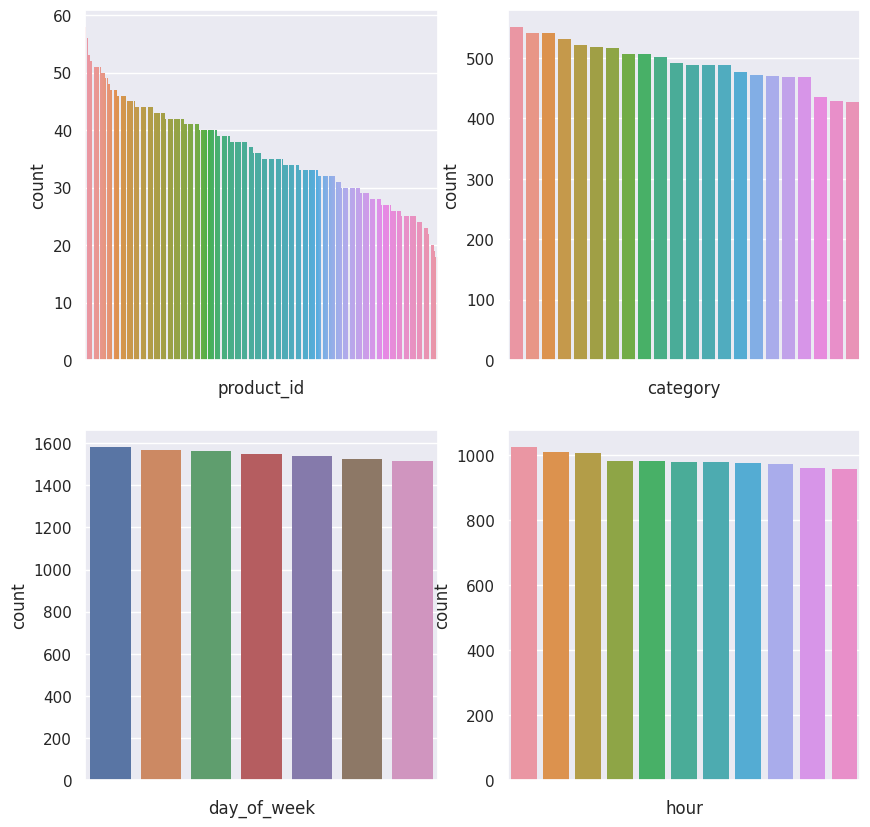

In [97]:
cats = ['product_id', 'category', 'day_of_week', 'hour']
idx = 0
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# axes[-1, -1].axis('off')
for i in list(range(2)):
  for j in list(range(2)):
    if idx < 5: 
      ax = sns.countplot(ax=axes[i, j], data=df, x=cats[idx], order=df[cats[idx]].value_counts().index, lw=0)
      ax.set(xticklabels=[])
      idx+=1

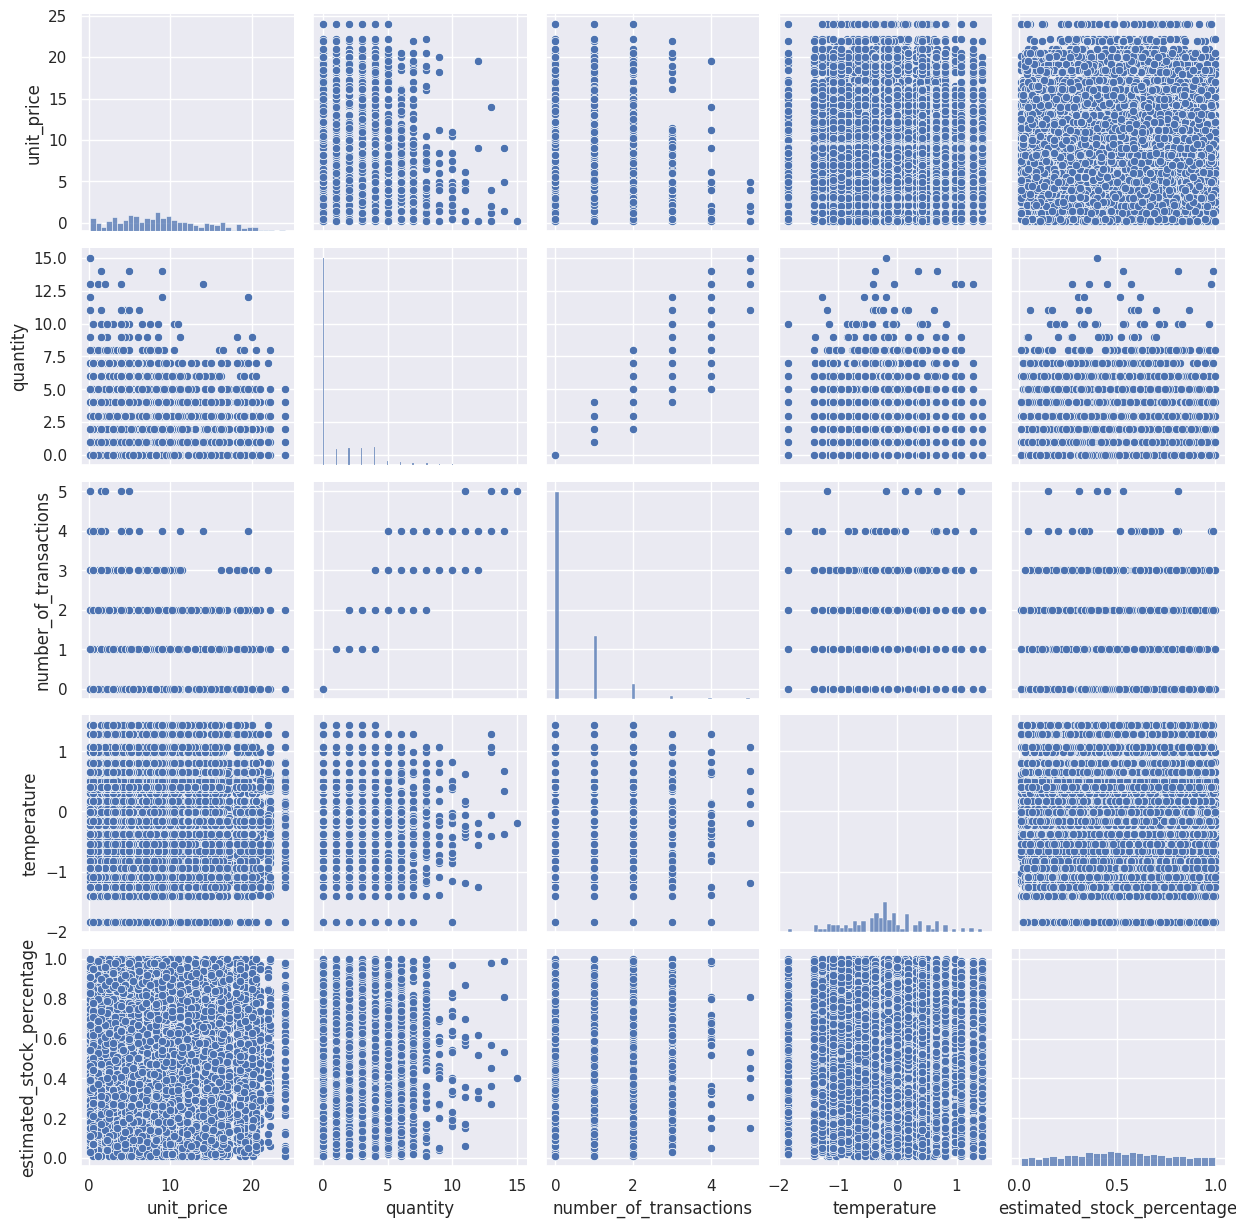

In [98]:
continuous = ['unit_price', 'quantity', 'number_of_transactions', 'temperature', 'estimated_stock_percentage']
sns.set(rc={'figure.figsize':(2, 2)})
sns.pairplot(df[continuous])

There are no distinct pattern that may help predict target variables. There are more ways to analyze this data, but give the narrow coverage of the data (only one week of sales) an in-depth analysis may not be worth it. We just go directly to building model to present a prototype of machine learning solution.

Copy the processed data frame before one-hot encoding. We make one-hot encoding of quite many columns

In [99]:
df_copy = df.copy()

In [100]:
df = pd.get_dummies(df, columns=['product_id', 'category', 'day_of_month', 'day_of_week', 'hour'])
len(df.columns)

352

In [101]:
df.head()

,quantity,number_of_transactions,temperature,unit_price,estimated_stock_percentage,product_id_00e120bb-89d6-4df5-bc48-a051148e3d03,product_id_01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,product_id_01ff0803-ae73-4234-971d-5713c97b7f4b,product_id_02b1a5a2-cd74-4e64-80f0-4667372bc394,product_id_0363eb21-8c74-47e1-a216-c37e565e5ceb,...,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19
0,3.0,1.0,-0.02885,11.19,0.89,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,1.0,-0.02885,1.49,0.14,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,-0.02885,14.19,0.67,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,-0.02885,20.19,0.82,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,-0.02885,8.19,0.05,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10845 entries, 0 to 10844
Columns: 352 entries, quantity to hour_19
dtypes: float64(5), uint8(347)
memory usage: 4.0 MB


In [103]:
df.columns

Index(['quantity', 'number_of_transactions', 'temperature', 'unit_price',
       'estimated_stock_percentage',
       'product_id_00e120bb-89d6-4df5-bc48-a051148e3d03',
       'product_id_01f3cdd9-8e9e-4dff-9b5c-69698a0388d0',
       'product_id_01ff0803-ae73-4234-971d-5713c97b7f4b',
       'product_id_02b1a5a2-cd74-4e64-80f0-4667372bc394',
       'product_id_0363eb21-8c74-47e1-a216-c37e565e5ceb',
       ...
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19'],
      dtype='object', length=352)

We're going to build the predictive model using random forest with the sparse data using hyperparameter tuning.

Prepare the X and y. Scale the X. 

In [104]:
X_unscaled = df.drop(columns = ['estimated_stock_percentage'])
y = df['estimated_stock_percentage']

scaler = StandardScaler()
scaler.fit(X_unscaled)
X = scaler.transform(X_unscaled)

### Random Forest

Determine the splits for cross-validation. Instantiate the model. Perform the grid search to get the best model. Wrap it all in a function, we're going to build a functionality where we perform training only if the model doesn't exist already.

In [105]:
rf_model_file = 'rf_model.pkl'

def cv_hyperparameter_rf(X, y):

  if (os.path.isfile(rf_model_file)==False): 

    rf = RandomForestRegressor()
    cv = KFold(n_splits=5)
    param_grid ={'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}

    grid_search = GridSearchCV(rf, param_grid=param_grid, cv=cv)
    grid_search.fit(X, y)
    
    print('MEAN CROSS-VALIDATION SCORE: ', grid_search.best_score_)
    print('BEST HYPERPARAMETERS: ', grid_search.best_params_)
    print('Finished with hyperparamer tuning with cross-validation. Now on to training the model with the best hyperparameters.')
    n_estimators = grid_search.best_params_['n_estimators']
    max_depth = grid_search.best_params_['max_depth']

    rf_model = train_rf(X, y, n_estimators, max_depth)

    return rf_model

def train_rf(X, y, n_estimators, max_depth):
  rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=12)
  rf_model = rf.fit(X_train, y_train)
  
  y_pred = rf_model.predict(X_test)
  mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)

  print('MEAN ABSOLUTE ERROR OF TRAINED BEST MODEL: ', mae)

  pickle.dump(rf_model, open(rf_model_file, 'wb'))

  return rf_model

In [106]:
cv_hyperparameter_rf(X, y)

MEAN CROSS-VALIDATION SCORE:  -0.0008190157608661819
BEST HYPERPARAMETERS:  {'max_depth': 3, 'n_estimators': 100}
Finished with hyperparamer tuning with cross-validation. Now on to training the model with the best hyperparameters.
MEAN ABSOLUTE ERROR OF TRAINED BEST MODEL:  0.22386711824693759


Visualize feature importance

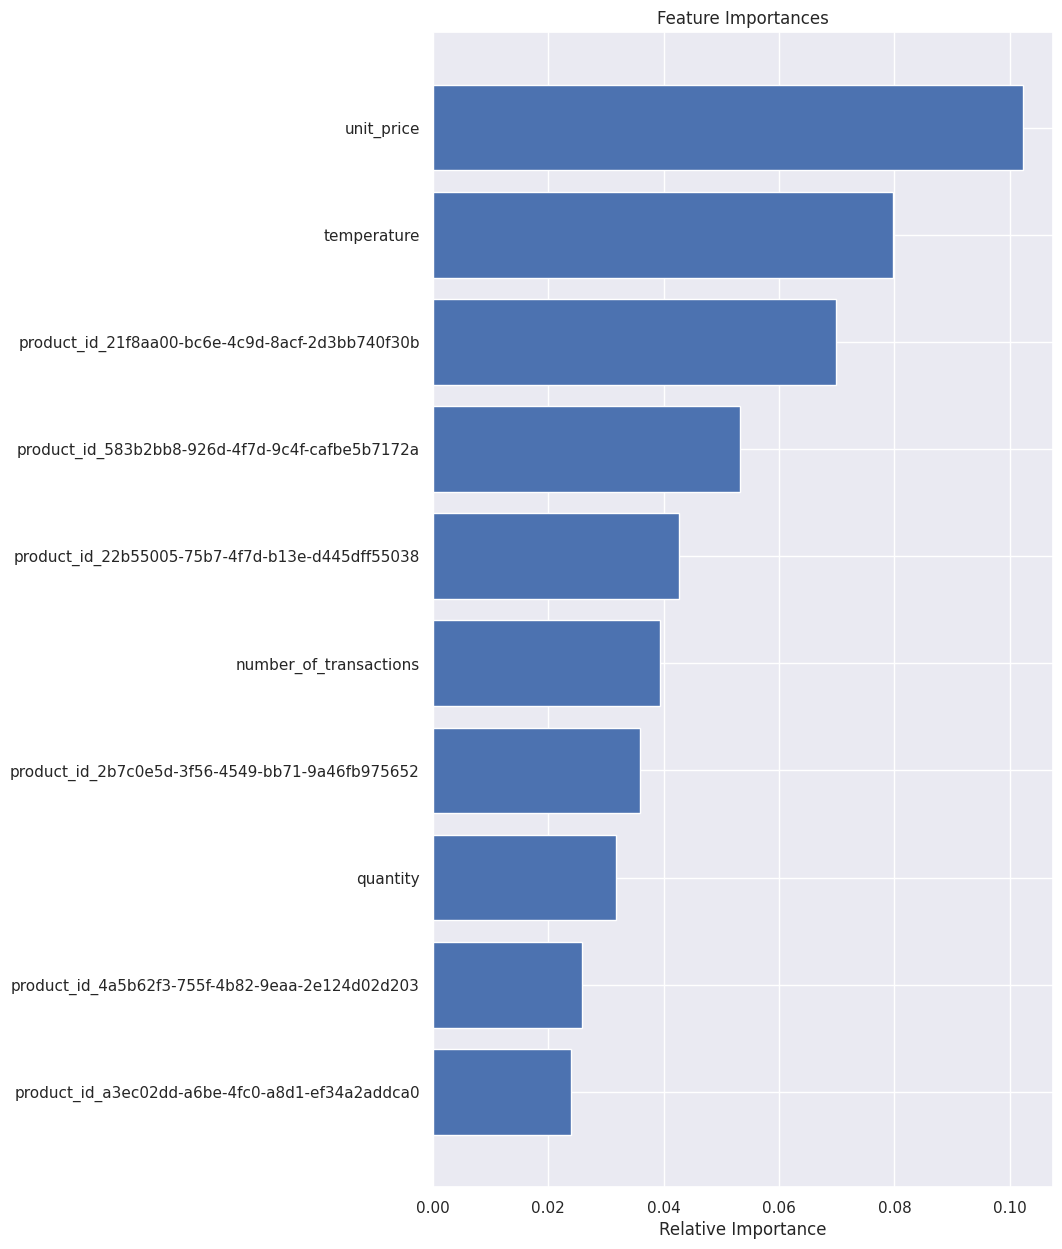

In [160]:
rf_model = pickle.load(open(rf_model_file, 'rb'))

features = [i.split("__")[0] for i in X_unscaled.columns]
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]

fig, ax = plt.subplots(figsize=(8, 15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [156]:
importances[indices]

array([0.10235405, 0.07966503, 0.0698669 , 0.05319286, 0.04261596,
       0.03940886, 0.03595175, 0.03179666, 0.02581293, 0.02392528])

In [142]:
importances[55]

0.06986690428934252